The dataset is retrieved from the Survey of Consumer Finances (SCF). The 2007-2009 dataset contains survey results about household demographics, net worth, assets in 2017 (pre-crisis) and 2009 (post-crisis). The 2016 dataset is the most recent as of the time that this project is conducted (18 August 2021). 

- Source links for Excel/CSV files:
[2007-2009](https://www.federalreserve.gov/econres/scf_2009p.htm) [2016](https://www.federalreserve.gov/econres/scf_2016.htm)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import pandas_datareader.data as web
import yfinance as yf

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# Load 2007-2009 Excel data 
# May takes some time to load

dataset = pd.read_excel('StockData/SCFP2009panel.xlsx', engine='openpyxl', sheet_name='SCFP2009panel', header=0)

In [3]:
# 19285, 515 - excluding a header row

assert dataset.shape == (19285, 515), "Incorrect data size"

In [4]:
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,1,11,"11,668.1342",47,3,12,2,1,0,2,...,-21.0526,-32.9318,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,270.4031,57
1,1,12,"11,823.4565",47,3,12,2,1,0,2,...,-21.0526,-32.9318,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,249.5936,57
2,1,13,"11,913.2284",47,3,12,2,1,0,2,...,-50.0000,-32.9318,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,209.2334,57
3,1,14,"11,929.3943",47,3,12,2,1,0,2,...,-33.3333,-32.9318,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,209.2732,57
4,1,15,"11,917.7229",47,3,12,2,1,0,2,...,-38.5965,-32.9318,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,232.6908,57


In [5]:
print(dataset.columns.tolist())

['YY1', 'Y1', 'WGT09', 'AGE07', 'AGECL07', 'EDUC07', 'EDCL07', 'MARRIED07', 'KIDS07', 'LIFECL07', 'FAMSTRUCT07', 'RACECL', 'H_RACECL', 'RACE', 'H_RACE', 'OCCAT107', 'OCCAT207', 'INDCAT07', 'HHEALTH07', 'SPHEALTH07', 'INCOME07', 'WAGEINC07', 'BUSSEFARMINC07', 'INTDIVINC07', 'KGINC07', 'SSRETINC07', 'TRANSFOTHINC07', 'PENACCTWD07', 'NORMINC07', 'RISK07', 'PSAVING07', 'WSAVED07', 'SAVED07', 'SAVRES1', 'SAVRES2', 'SAVRES3', 'SAVRES4', 'SAVRES5', 'SAVRES6', 'SAVRES7', 'SAVRES8', 'SAVRES9', 'SPENDMOR07', 'LATE6007', 'USPELL07', 'AGEFT07', 'AGEALL07', 'POSTRWORK07', 'RFULL07', 'BSHOPNONE07', 'BSHOPGRDL07', 'BSHOPMODR07', 'ISHOPNONE07', 'ISHOPGRDL07', 'ISHOPMODR07', 'BCALL07', 'BMAGZNEWS07', 'BMAILADTV07', 'BINTERNET07', 'BFRIENDWORK07', 'BFINPRO07', 'BSELF07', 'BDONT07', 'BOTHER07', 'ICALL07', 'IMAGZNEWS07', 'IMAILADTV07', 'IINTERNET07', 'IFRIENDWORK07', 'IFINPRO07', 'ISELF07', 'IDONT07', 'IOTHER07', 'BFINPLAN07', 'IFINPLAN07', 'APPLIED07', 'DENIED07', 'FULLAMT07', 'FEARED07', 'CHECKING07', '

## Data exploration and cleaning

As the dataset consists of 515 columns, it looks wise to condense it with necessary features suitable for business questions.

The objective of this project is to gauge individual's risk tolerance (as dependent variable) in response to three major feature categories: demographic, financial and behavioural.

#### Dependent variable: risk tolerance
- Risk tolearance ratio: as a function of **total risky assets / total assets**
- Total assets = total risky assets + total risk-free assets
- Risky assets: NMMFXX, STOCKSXX, BONDXX
- Risk-free assetes: LIQXX, CDSXX, SAVBNDXX, CASHLIXX
- XX is a placeholder for a specific year, i.e. XX=07 for the Year of 2007

#### Normalize the risk tolearance for 2009
Normalize risky assets with the price of a stock index (S&P500) in 2007 versus 2009.

#### Independent variables
- demographic: AGE, EDCL, MARRIED, OCCAT1
- financial: WSAVED, NETWORTH, INCOME
- behavioural: RISK

### Calculate risk tolerance ratio by row

In [39]:
# SP500 index data for normalization
# pandas_datareader does not have SP500 data as early as 2007 / 2009

def get_sp500(year):
    '''Return a series of SP500 price indices for the year specified
    Source of the data is Yahoo Finance
    '''
    
    try:
        sp500 = yf.Ticker('^GSPC')
        start = dt.datetime(int(year),1,1)
        end = dt.datetime(int(year),12,31)
        
    except:
        raise ValueError('The input year is out of the data range')
    
    return sp500.history(start=start, end=end)['Close']

In [40]:
# Get average closing price for each year of 2007 and 2009
# And calculate the normalizer

Avg_SP07 = get_sp500(2007).mean()
Avg_SP09 = get_sp500(2009).mean()
normalizer = Avg_SP09 / Avg_SP07

print(f'Average stock index in 2007 and 2009 respectively: {Avg_SP07:.2f}, {Avg_SP09:.2f}')

Average stock index in 2007 and 2009 respectively: 1477.22, 947.21


In [41]:
def calculate_RT_ratio(df, year:int):
    ''' Calculate risk tolerance ratio for individual in a particular year.
    Return Pandas Series. 
    '''
    
    # Check for input 
    if len(str(year) ) == 4:
        year = str(year)[2:]
    else:
        raise ValueError('Input year must follow the 4-digit format YYYY')
    
    risky_cols = ['NMMF', 'STOCKS', 'BOND']
    riskfree_cols = ['LIQ', 'CDS', 'SAVBND', 'CASHLI']
    
    risky_cols = [col+year for col in risky_cols]
    riskfree_cols = [col+year for col in riskfree_cols]
    
    try:
        risky = df.loc[:, risky_cols].sum(axis=1)
        riskfree = df.loc[:, riskfree_cols].sum(axis=1)
        total = risky + riskfree
        
    except:
        print('The input dataframe does not have required columns')

    return risky / total


In [42]:
# Get risk tolerance rate

RT07 = calculate_RT_ratio(dataset, 2007)
RT09 = calculate_RT_ratio(dataset, 2009)

# Normalize risk tolerance ratio in 2009 with SP500 

RT09 = RT09 * normalizer

In [43]:
# Update dataset

dataset['RT07'] = RT07
dataset['RT09'] = RT09

In [44]:
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RT07,RT09
0,1,11,"11,668.1342",47,3,12,2,1,0,2,...,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,270.4031,57,0.0000,0.3303
1,1,12,"11,823.4565",47,3,12,2,1,0,2,...,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,249.5936,57,0.0000,0.3119
2,1,13,"11,913.2284",47,3,12,2,1,0,2,...,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,209.2334,57,0.0000,0.3078
3,1,14,"11,929.3943",47,3,12,2,1,0,2,...,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,209.2732,57,0.0000,0.2194
4,1,15,"11,917.7229",47,3,12,2,1,0,2,...,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,232.6908,57,0.0000,0.2653


### Clean dataset

In [45]:
# Drop rows containing null values

dataset=dataset.dropna(axis=0)

dataset=dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

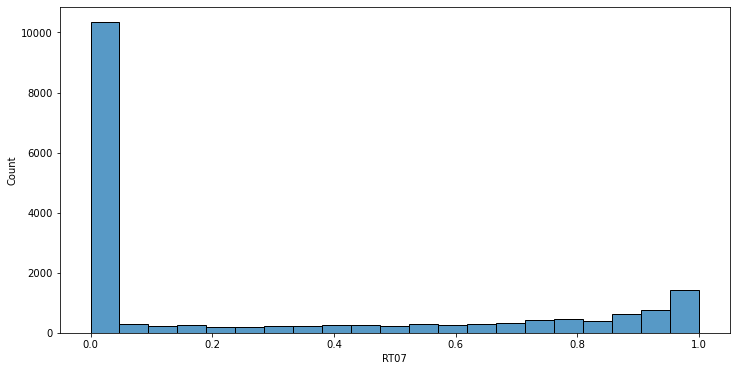

In [47]:
sns.histplot(dataset['RT07']);

### Condense dataframe

In [ ]:
features = ['AGE', 'EDCL', 'MARRIED', 'OCCAT1', 'WSAVED', 'NETWORTH', 'INCOME', 'RISK']